In [126]:
!pip install pytorch-forecasting
import pytorch_lightning as pl
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models import TemporalFusionTransformer

In [127]:
data = pd.read_csv("https://raw.githubusercontent.com/AdamSioud/BRAIN-MICROSOFT-HACKATHON/main/datasets/catchdata/CAPTURE_QUANTITY.csv")
data.head()
data["TIME_INDEX"] = data["PERIOD"] - data["PERIOD"].min()
data.head()
data = data.drop("STATUS",1)
data = data.drop("MEASURE",1)
data = data.drop("AREA.CODE",1)
data["PERIOD"] = data["PERIOD"].astype(str)
data["COUNTRY"] = data["COUNTRY.UN_CODE"].astype(str)
data = data.drop("COUNTRY.UN_CODE",1)
data["SPECIES_CODE"] = data["SPECIES.ALPHA_3_CODE"]
data = data.drop("SPECIES.ALPHA_3_CODE",1)
data = data.loc[data['SPECIES_CODE'] == "SAL"]
data = data.loc[data["VALUE"] != 0.0]
data = data.loc[data["COUNTRY"] == "578"]
data = data[59:]
data

/tmp/ipykernel_702/1586927679.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop("STATUS",1)
/tmp/ipykernel_702/1586927679.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop("MEASURE",1)
/tmp/ipykernel_702/1586927679.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop("AREA.CODE",1)
/tmp/ipykernel_702/1586927679.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop("COUNTRY.UN_CODE",1)
/tmp/ipykernel_702/1586927679.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop("S

,PERIOD,VALUE,TIME_INDEX,COUNTRY,SPECIES_CODE
534275,2019,16.0,69,578,SAL
534276,2018,20.0,68,578,SAL
534277,2017,9.0,67,578,SAL
534278,2016,6.0,66,578,SAL
534279,2015,4.0,65,578,SAL
...,...,...,...,...,...
534340,1954,1200.0,4,578,SAL
534341,1953,1100.0,3,578,SAL
534342,1952,1000.0,2,578,SAL
534343,1951,900.0,1,578,SAL


In [128]:
max_encoder_length = 50
max_prediction_length = 10
training_cutoff = "2010"  # day for cutoff

training = TimeSeriesDataSet(
    data = data.loc[data["PERIOD"] < "2017"],
    time_idx= "TIME_INDEX",
    target= "VALUE",
    # weight="weight",
    group_ids=["COUNTRY", "SPECIES_CODE"],
    max_encoder_length=60,
    max_prediction_length=max_prediction_length,
    min_encoder_length = 0,
    min_prediction_length = 1,
    static_categoricals=["COUNTRY","SPECIES_CODE"],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["TIME_INDEX"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["VALUE"],
    allow_missing_timesteps = True,
    add_encoder_length=True
)

In [129]:
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 128
train_dataloaders = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloaders = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)

In [130]:
# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    gradient_clip_val=0.1,
    limit_train_batches=30,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [131]:

# create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=100,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
tft.size() # 29.6k parameters in model# fit network

Number of parameters in network: 18.2k


18200

In [132]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloaders,
    val_dataloaders=val_dataloaders
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2     
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 708   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Validation sanity check: 0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 65. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [133]:
from pytorch_forecasting.metrics import MAE
import torch
# load the best model according to the validation loss (given that
# we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)# calculate mean absolute error on validation set
actuals = torch.cat([y for x, y in val_dataloaders])
predictions = best_tft.predict(val_dataloaders)
MAE(predictions, actuals)

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [134]:
from pytorch_forecasting.metrics import SMAPE # calculate metric by which to display
predictions, x = best_tft.predict(val_dataloaders)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort lossesraw_predictions, x = best_tft.predict(val_dataloader, mode="raw, return_x=True)# show only two examples for demonstration purposes
for idx in range(2):
    best_tft.plot_prediction(
        x,
        raw_predictions,
        idx=indices[idx],
        add_loss_to_title=SMAPE()
    )

ValueError: too many values to unpack (expected 2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:781: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
LR finder stopped early after 31 steps due to diverging loss.
Restoring states from the checkpoint path at /home/jovyan/lr_find_temp_model_7725bbd8-b04b-4008-8ca5-ec88aceee4e8.ckpt
Failed to compute suggesting for `lr`. There might not be enough points.
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pytorch_lightning/tuner/lr_finder.py", line 176, in suggestion
    min_grad = np.gradient(loss).argmin()
  File "<__array_function__ internals>", line 5, in gradient
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/nu

suggested learning rate: None


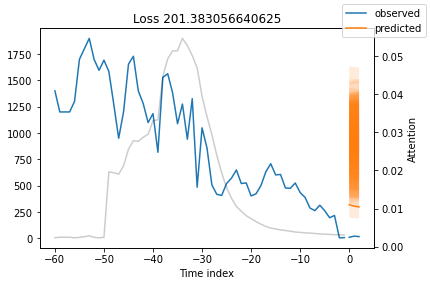

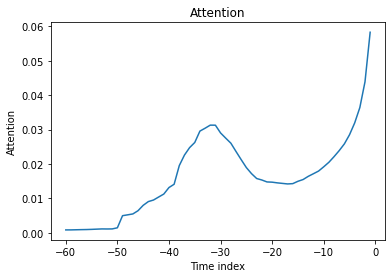

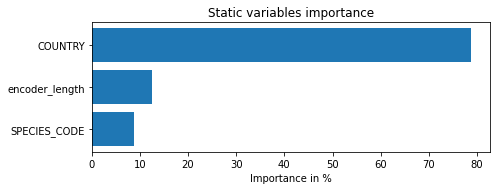

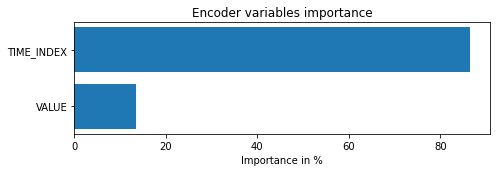

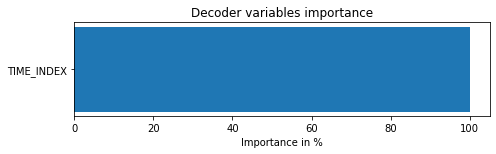

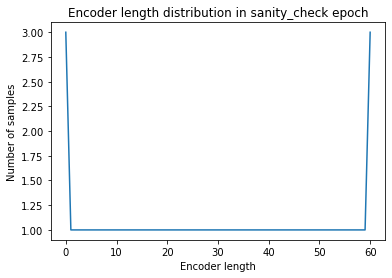

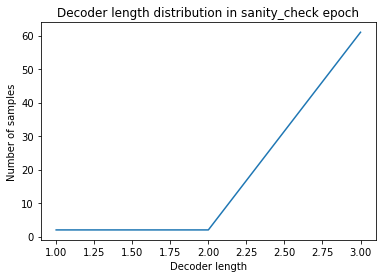

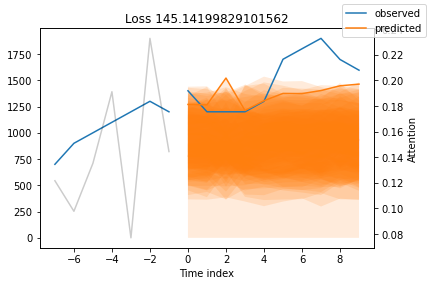

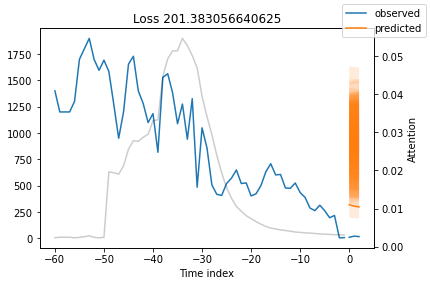

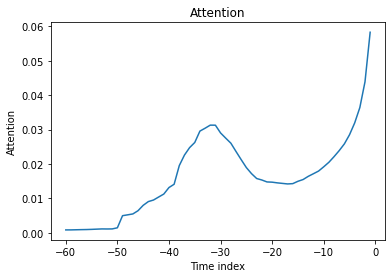

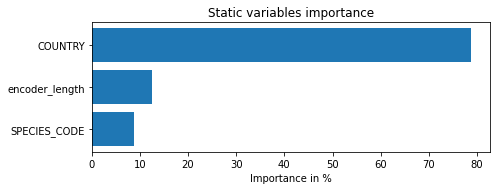

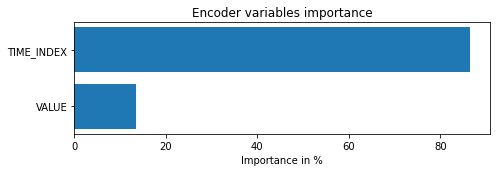

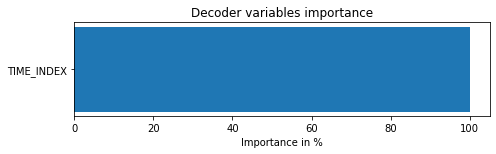

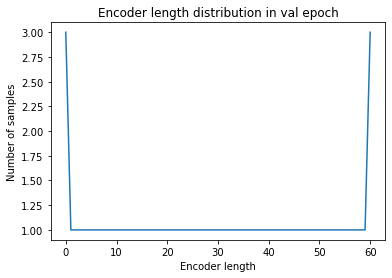

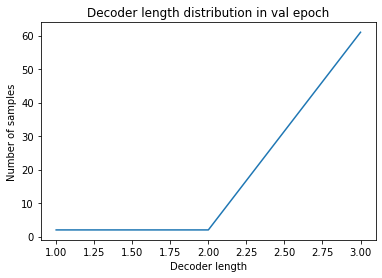

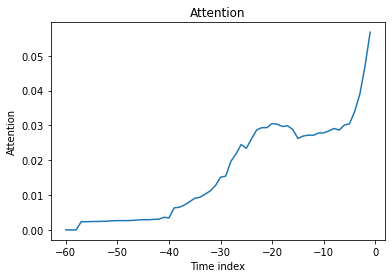

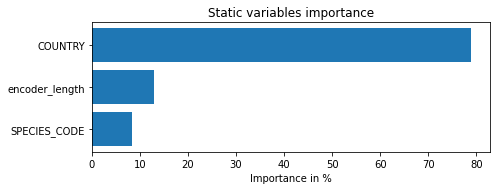

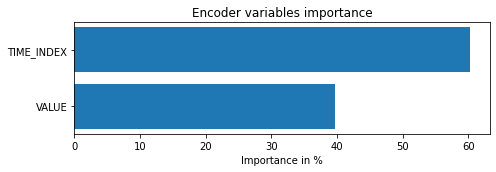

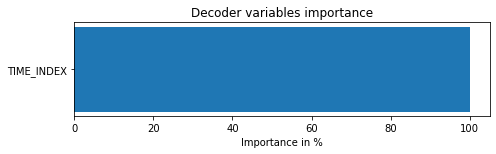

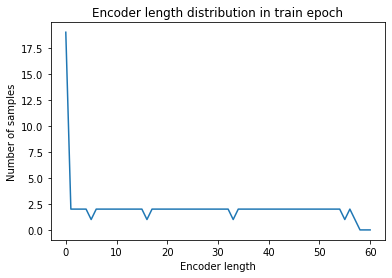

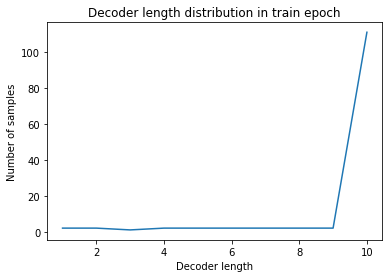

In [ ]:
# find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
res = trainer.tuner.lr_find(
    tft, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloaders, early_stop_threshold=1000.0, max_lr=0.3,
)
print(f"suggested learning rate: {res.suggestion()}")

Failed to compute suggesting for `lr`. There might not be enough points.
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pytorch_lightning/tuner/lr_finder.py", line 176, in suggestion
    min_grad = np.gradient(loss).argmin()
  File "<__array_function__ internals>", line 5, in gradient
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/function_base.py", line 1053, in gradient
    raise ValueError(
ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
Failed to compute suggesting for `lr`. There might not be enough points.
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/pytorch_lightning/tuner/lr_finder.py", line 176, in suggestion
    min_grad = np.gradient(loss).argmin()
  File "<__array_function__ internals>", line 5, in gradient
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/fun

suggested learning rate: None


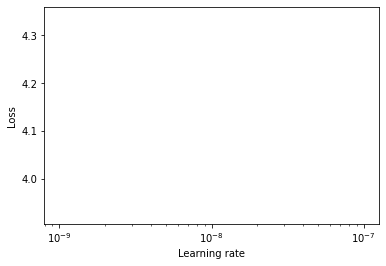

In [136]:
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloader,
)